# VCGC: Vertex Coloring with Grover's Circuit 
Rudimentary Curcuit To Run Grover's Search Algorithm for a vertex coloring instance on the AER simulator and IBM's Quantum Computer. 

1. Prepare the circuit and add the uniform state preparation operator.

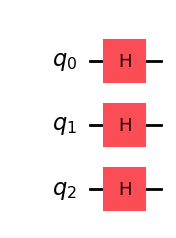

In [34]:
from qiskit import *
import matplotlib.pyplot as plt
import numpy as np  

# Create a Quantum Circuit acting on a quantum register of 5 qubits
qc = QuantumCircuit(5,5)

# Subcircuit for uniform state preparation operator
spo = QuantumCircuit(3,name="state_prep")

# Add a H gate on all qubits except the last one
# This will give the superposition of all the qubits except the last one
for qubit in range(3):
    spo.h(qubit)
qc.x(4)
qc.h(4)
qc.barrier()

# qc.decompose(gates_to_decompose="state_prep").draw('mpl')
spo.draw('mpl')

2. Manually creating the oracle circuit for evaulating the scaled down vertex coloring problem shown below

![Simple Vertex Coloring problem](vertex_coloring_instance.png)

In [ ]:
# Create a quantum subcircuit for grover oracle
from tweedledum.synthesis import xag_synth  # Import XAG synthesis
from qiskit.circuit.classicalfunction.utils import tweedledum2qiskit
from qiskit.circuit.classicalfunction import ClassicalFunction
from tweedledum.qiskit import *
from qiskit.circuit.classicalfunction.types import Int1
import inspect
from textwrap import dedent
from tweedledum.bool_function_compiler.bitvec import BitVec
from tweedledum.bool_function_compiler.bool_function import BoolFunction

def grover_oracle_func(v0: BitVec(2), v1: BitVec(2), v2: BitVec(2), v3: BitVec(2)) -> BitVec(1):
    # Define constants with explicit bit patterns
    pattern_01 = BitVec(2, value=1)  # '01' in binary
    pattern_00 = BitVec(2, value=0)  # '00' in binary
    
    c0 = (v0 != v1)
    c1 = (v0 != v2)
    c2 = (v2 != pattern_01)
    c3 = (v2 != v3)
    c4 = (v1 != v2)
    c5 = (v1 != pattern_00)
    return (c0 and c1 and c2 and c3 and c4 and c5)

cf1 = BoolFunction(grover_oracle_func)
def xag_synthesizer(cf):
    """Custom synthesizer using XAG synthesis instead of PKRM""" 

    # Get the LogicNetwork object from cf.network
    logic_network = cf._logic_network
    
    # Perform XAG synthesis ONCE and store the result
    tweedledum_circuit = xag_synth(logic_network)
    print(f"Number of qubits in Tweedledum circuit: {tweedledum_circuit.num_qubits()}")
    print(tweedledum_circuit)
    qc_qiskit = to_qiskit(tweedledum_circuit, circuit_type="gatelist")

    return qc_qiskit

grover_oracle = xag_synthesizer(cf1)
grover_oracle.name = "grover_oracle_func"
grover_oracle.draw('mpl')

KeyError: 'print'

3. Defining the diffusion operator

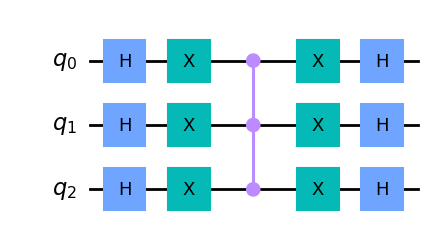

In [36]:
# Create a quantum subcircuit for grover diffusion operator
grover_diffusion = QuantumCircuit(3, name="grover_diffusion")
grover_diffusion.h([0,1,2])
grover_diffusion.x([0,1,2])
grover_diffusion.ccz(0,1,2)
grover_diffusion.x([0,1,2])
grover_diffusion.h([0,1,2])

grover_diffusion.draw('mpl',style='clifford')

4. Connect the whole circuit together together for the first iteration

In [37]:
# from qiskit.circuit.classicalfunction import classical_function
# from qiskit.circuit.classicalfunction.types import Int1
 
# @classical_function
# def grover_oracle(a: Int1, b: Int1, c: Int1) -> Int1:
#     return (a and not b and ( c ^ a))
 
# grover_oracle_synth = grover_oracle.synth(registerless=True)
# grover_oracle_synth.decompose().draw('mpl')

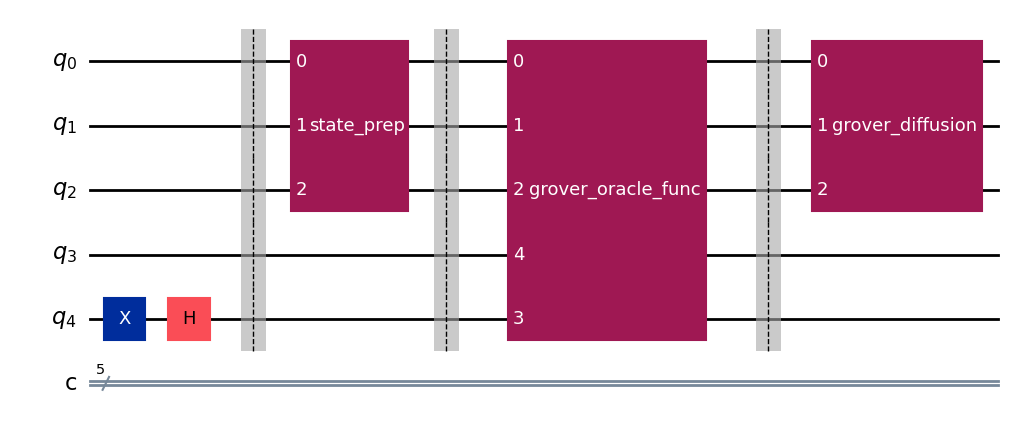

In [38]:
# Combining the subcircuits to form the complete Grover's algorithm
qc.append(spo, [0, 1, 2])
qc.barrier()
qc.append(grover_oracle, [0,1,2,4,3])
qc.barrier()
qc.append(grover_diffusion, [0,1,2])
# qc.barrier()
# qc.append(grover_oracle, [0,1,2,3,4])
# qc.barrier()
# qc.append(grover_diffusion, [0,1,2])


qc.draw('mpl')

5. Add measurements and running the circuit of the AER simulator

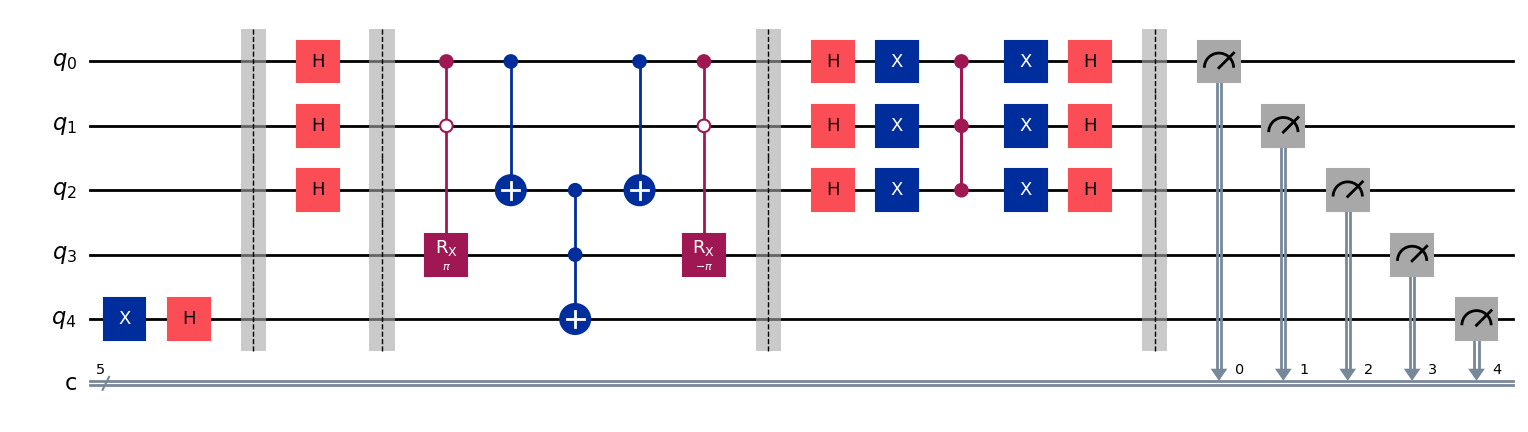

In [39]:

# qc.measure([0, 1, 2], [0, 1, 2]) # Measure the first 3 qubits
qc.measure_all(add_bits=False)
qc_decomposed : QuantumCircuit = qc.decompose(gates_to_decompose=["state_prep", "grover_oracle_func", "grover_diffusion"])
qc_decomposed.draw('mpl')


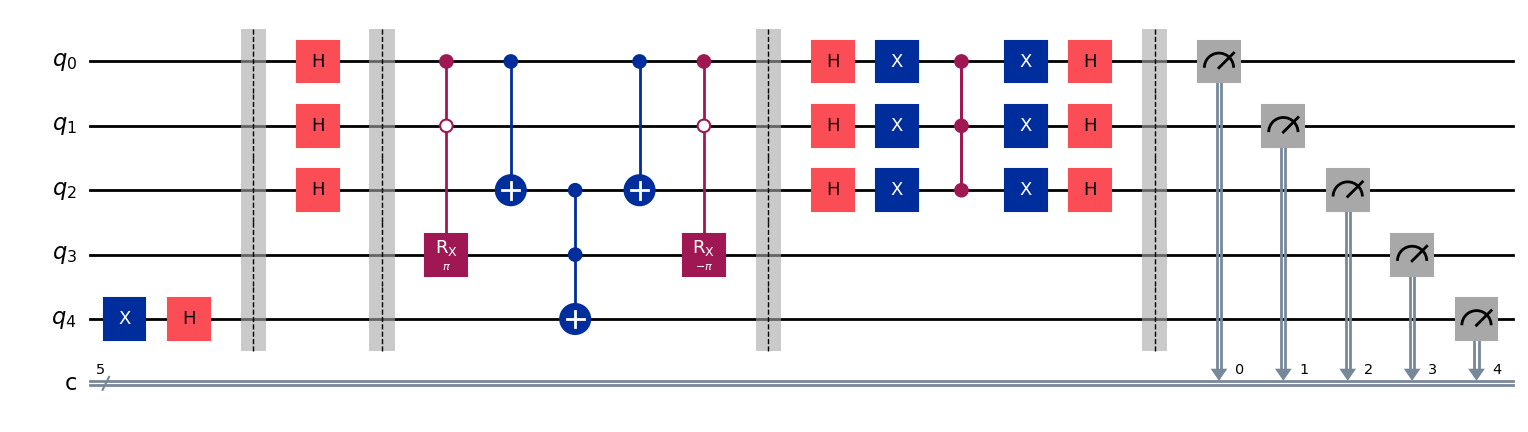

In [40]:
qc_decomposed.draw('mpl',fold=-1)

In [6]:
from qiskit_aer import Aer
# import basic plot tools
from qiskit.visualization import plot_histogram, plot_distribution

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')
result = qasm_sim.run(qc_decomposed).result()
counts = result.get_counts()

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

# Use the function to process the counts
new_counts = process_counts(counts)
print(new_counts)
plot_distribution(new_counts)

# plot_histogram(counts)

NameError: name 'qc_decomposed' is not defined

6. Running on a real device

{'000': 40, '001': 784, '010': 38, '011': 37, '100': 24, '101': 39, '110': 26, '111': 36}


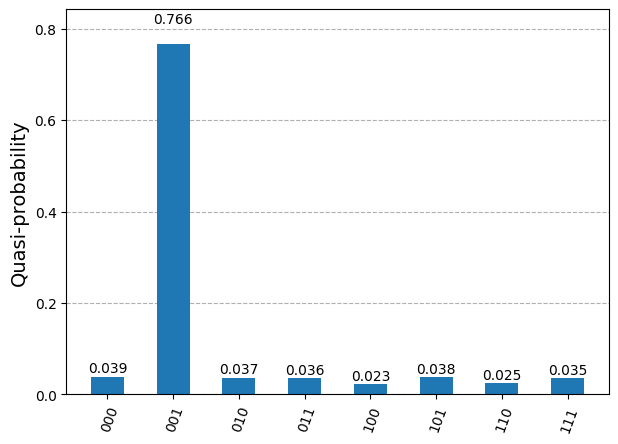

In [42]:
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram, plot_distribution
from qiskit import transpile

# Creating the backend
qasm_sim = Aer.get_backend('qasm_simulator')

# Get the basis gates supported by the simulator
basis_gates = qasm_sim.configuration().basis_gates

# Transpile the circuit to the supported basis gates
qc_transpiled = transpile(qc_decomposed, basis_gates=basis_gates)

# Now run the transpiled circuit
result = qasm_sim.run(qc_transpiled).result()
counts = result.get_counts()

# A function to extract the counts of the useful qubits
def process_counts(counts, num_qubits=3):
    # New dictionary to store our results in.
    new_counts = {f'{i:0{num_qubits}b}': 0 for i in range(2**num_qubits)}

    # Loop through the counts dictionary, adding the value to the 
    # respective key in new_counts based on what state the show_qubit is in
    for count in counts:
        count_idx = (len(count) - num_qubits)
        new_counts[count[count_idx:count_idx+num_qubits]] += counts[count]
    
    return new_counts

# Use the function to process the counts
new_counts = process_counts(counts)
print(new_counts)
plot_distribution(new_counts)

# Dynamic Decoupling Circuit (JB's code)
This code snippet demonstrates the use of dynamic decoupling to mitigate decoherence in quantum circuits. The `PassManager` is configured with the `ALAPScheduleAnalysis` and `PadDynamicalDecoupling` passes to apply dynamic decoupling sequences to the circuit. The optimized circuits are then transpiled and their depths are printed.

In [44]:
from qiskit.transpiler import PassManager
from qiskit.circuit.library import XGate
from qiskit_ibm_runtime.transpiler.passes.scheduling import ALAPScheduleAnalysis, PadDynamicalDecoupling, DynamicCircuitInstructionDurations
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
target = backend.target
durations = DynamicCircuitInstructionDurations.from_backend(backend=backend)


optimized_pm = generate_preset_pass_manager(target=target, optimization_level=3)
dd_rep = 8
dd_sequence = [XGate()] * dd_rep

optimized_pm.scheduling = PassManager([
    ALAPScheduleAnalysis(durations=durations),
    PadDynamicalDecoupling(
        durations=durations,
        dd_sequences=dd_sequence,
        pulse_alignment=16
    )
])
NUM_TRIAL = 10
transpiled_circuits = []
for i in range(NUM_TRIAL):
    transpiled_circuits.append(optimized_pm.run(qc))


depths = [circuit.depth() for circuit in transpiled_circuits]
print(depths)

[308, 302, 300, 302, 310, 308, 310, 300, 302, 300]


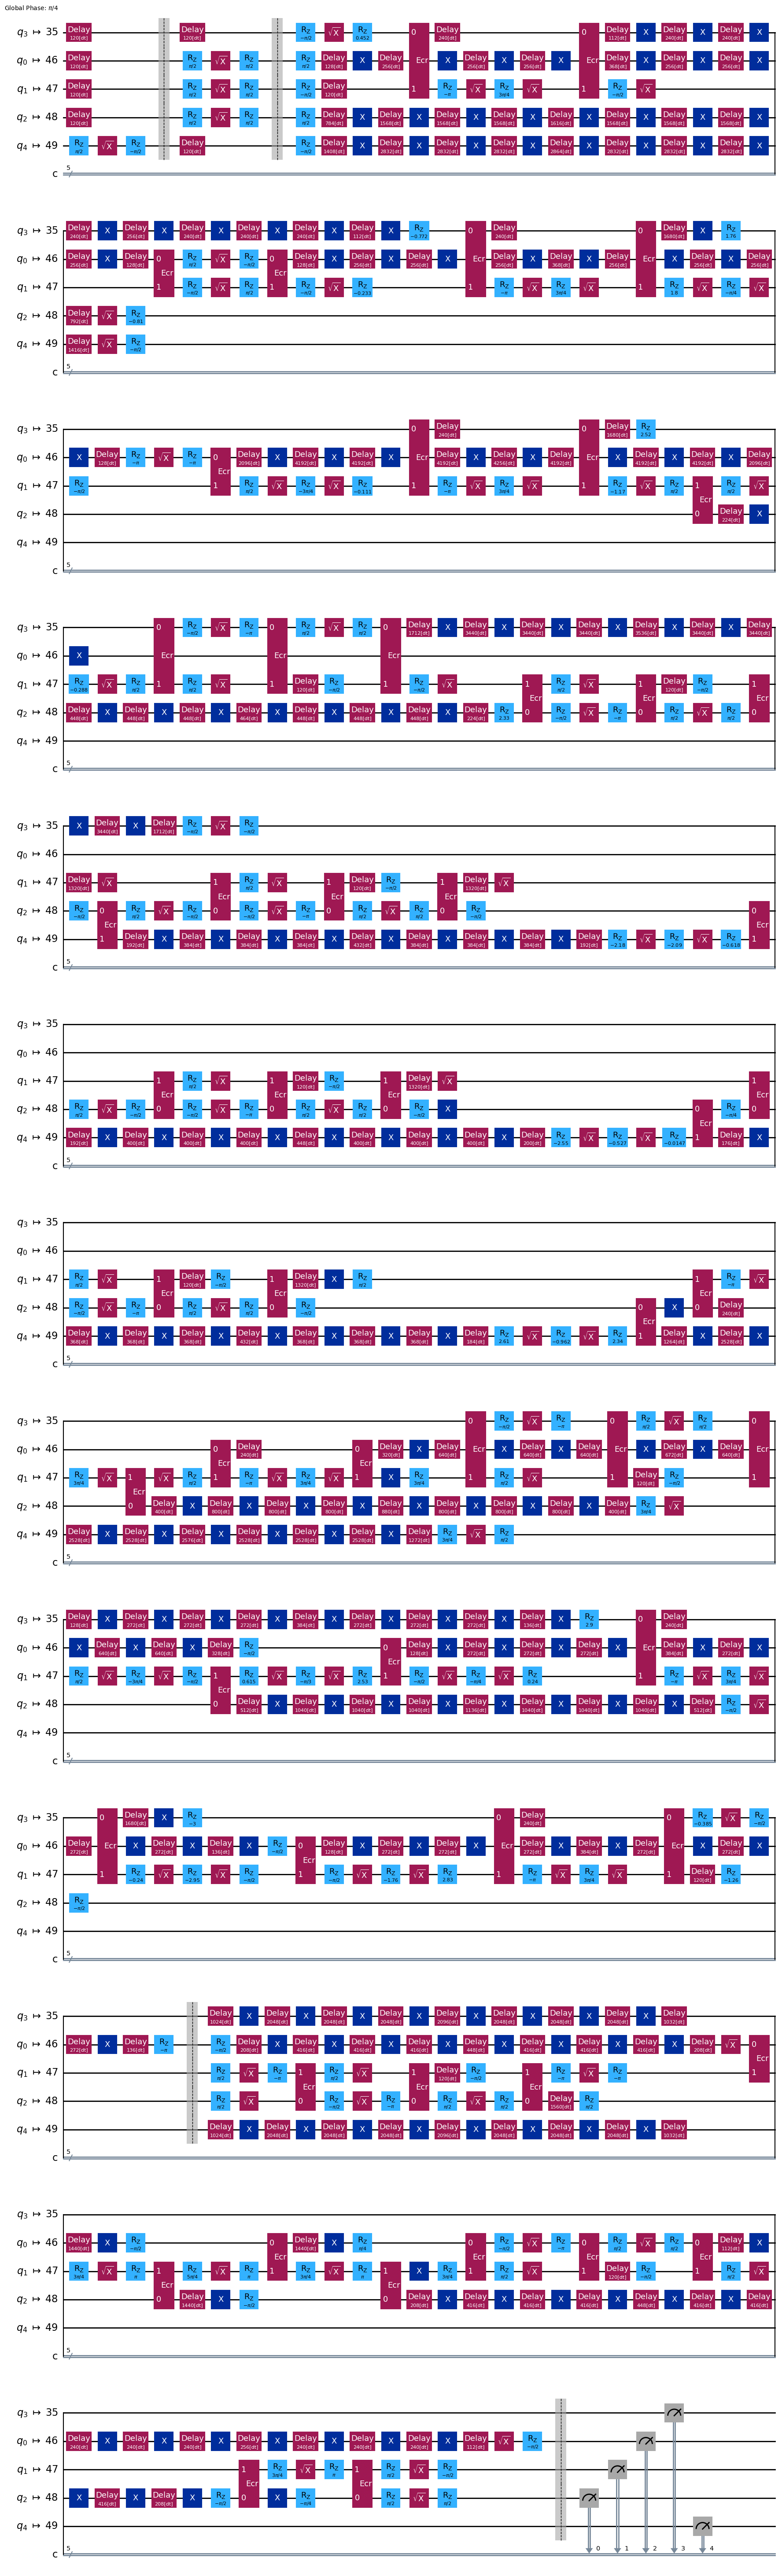

In [45]:
# Draw the circuit
transpiled_circuit = transpiled_circuits[1]
transpiled_circuit.draw('mpl', idle_wires=False,
                        )

In [46]:
# Listing the qubits used in the transpiled circuit
used_qubits = transpiled_circuit.layout.final_index_layout()
used_qubits

[48, 47, 46, 35, 49]

In [47]:
print(transpiled_circuit.depth())

302


In [ ]:
import mthree
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(used_qubits)
# mit.apply_correction(transpiled_circuit, used_qubits)


ValueError: dictionary update sequence element #0 has length 3; 2 is required

In [49]:
# Running the transpiled circuit using the sampler
from qiskit_ibm_runtime import Sampler
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
job = sampler.run([transpiled_circuit])

{'000': 812, '001': 3384, '010': 680, '011': 1422, '100': 739, '101': 1282, '110': 731, '111': 950}


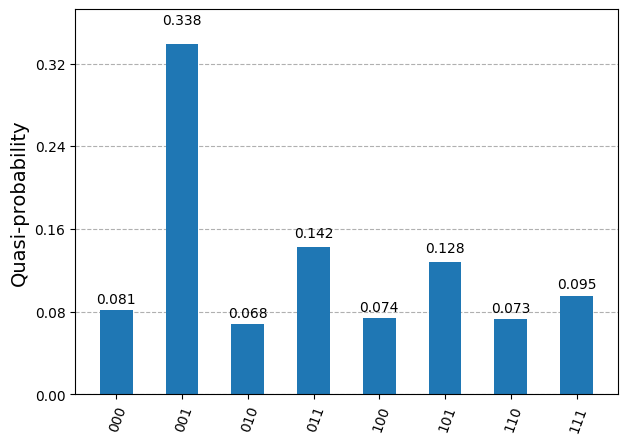

In [50]:
from qiskit.visualization import plot_distribution
result = job.result()
# result = service.job('cyvnd7m4raf0008epag0').result()
# Job with prob 0.432: cyvnd7m4raf0008epag0
# The above job has an optimized Toffoli gate applied to it

# Job with prob 0.336: cydx70c9b62g008jh290
# The above job has the original qiskit Toffoli gate applied to it
raw_counts = result[0].data.c.get_counts()
new_raw_counts = process_counts(raw_counts)
print(new_raw_counts)
plot_distribution(new_raw_counts)

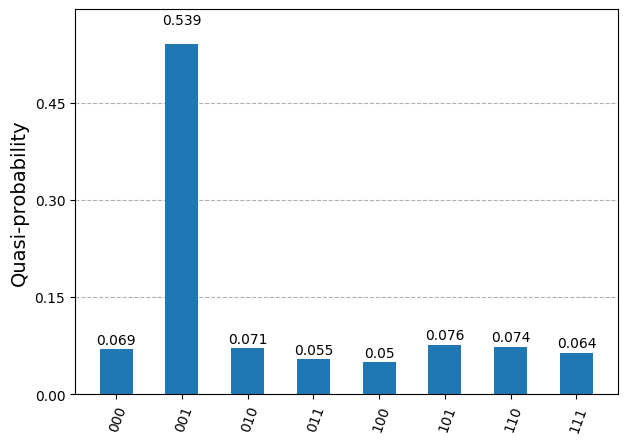

In [ ]:
# Applying the mitigation
quasi = mit.apply_correction(raw_counts, used_qubits)

mitigated_counts = {k: int(v*10_000) for k, v in quasi.items()}
new_mitigated_counts = process_counts(mitigated_counts)
plot_distribution(new_mitigated_counts)